# Heterogeneous/ Multi-Modal

*Binary Classification of Galaxy Morphologies Using Images Paired with Tabular Metadata.*

<img src="../../../_static/images/banner/spirals.png" class="banner-photo"/>

Mixed data analysis is one of the areas where deep learning really sets itself apart from traditional forms of statistics and machine learning. Neural networks are an effective way to logically encode and combine any type of data (image, text, time series, audio, tabular spreadsheets, video, etc) within the same analysis while converging toward the minimization a single *loss* metric. This leads to rich experiments that resemble real-world scenarios that resemble man-machine symbiosis. For example, consider combining a doctor's annotations with electronic medical records and histology imagery.

> *Due to the fact that these images were captured by different instruments that represent color differently, I removed the noisy 3-channel color information and proceeded with grayscale. Since the shapes of the features are dynamically passed into the model, the only difference between a single versus multi-channel workflow is changing the actual layers (e.g. `Conv1D` to `Conv2D`).*

---

## 💾 Data

Reference [Example Datasets](../../datasets.html) for more information.

In [6]:
from aiqc import datum
from aiqc.orm import Dataset

### Tabular Data

In [7]:
df = datum.to_df('galaxies.tsv')

Using the built-in structured data about 40 galaxies, we'll derive:

* A binary, categorical label: `morphology`.
* Categorical and numeric metadata features: `clarity`, `angle`.
* A manifest detailing where to find our image files: `url`.

In [8]:
df.head(3)

,morphology,clarity,angle,url
0,bar,0,face,https://raw.githubusercontent.com/aiqc/aiqc/ma...
1,bar,3,angle,https://raw.githubusercontent.com/aiqc/aiqc/ma...
2,bar,3,face,https://raw.githubusercontent.com/aiqc/aiqc/ma...


From a single `Dataset.Tabular` we'll specify a `Label` and `Feature` before encoding them.

In [9]:
shared_dataset = Dataset.Tabular.from_pandas(df)

### Image Data

Construct a `Dataset.Image` from that manifest and use it as a 2nd `Feature`.

In [10]:
urls = df['url'].tolist()

In [11]:
dataset_img = Dataset.Image.from_urls(urls)

🖼️ Ingesting Images 🖼️: 100%|████████████████████████| 40/40 [00:06<00:00,  5.96it/s]


In [12]:
example_images = Dataset.Image.to_pillow(id=dataset_img.id)

**Bar galaxies**

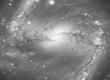

In [13]:
example_images[15]

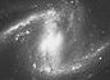

In [14]:
example_images[0]

Although it is easy enough to distinguish between the two types with the naked eye, you start to realize that a *bar* galaxy is almost like a degraded *spiral* galaxy. Like anything else, there is a gray area in whether or not the band of stars/ rectangle of light connecting the two main galactic arms is to be considered a "bar" or more of an oval.

**Spiral galaxies**

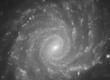

In [15]:
example_images[38]

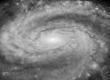

In [16]:
example_images[37]

---

## 🚰 Pipeline

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [27]:
from aiqc.mlops import Pipeline, Input, Target, Stratifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from aiqc.utils.encoding import div255, mult255

In [29]:
pipeline = Pipeline(
    inputs = [
        Input(
            dataset         = shared_dataset,
            exclude_columns = ['url'],
            encoders        = [
                Input.Encoder(StandardScaler(), columns=['clarity']),
                Input.Encoder(OneHotEncoder(),  columns=['angle'])
            ]
        ),
        
        Input(
            dataset = dataset_img,
            encoders = Input.Encoder(FunctionTransformer(div255, inverse_func=mult255))
        )
    ],
    
    target = Target(
        dataset = shared_dataset,
        column  = 'morphology',
        encoder = Target.Encoder(OrdinalEncoder())
    ),

    stratifier = Stratifier(
        size_test       = 0.125,
        size_validation = 0.175
    )
)


└── Info - System overriding user input to set `sklearn_preprocess.copy=False`.
	This saves memory when concatenating the output of many encoders.


└── Info - System overriding user input to set `sklearn_preprocess.sparse=False`.
	This would have generated 'scipy.sparse.csr.csr_matrix', causing Keras training to fail.



---

## 🧪 Experiment

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

Below we see two towers, feedforward for tabular data and convolutional for image data, that are eventually concatenated together.

In [30]:
from aiqc.mlops import Experiment, Architecture, Trainer
import tensorflow as tf
from tensorflow.keras import layers as l
from aiqc.utils.tensorflow import TrainingCallback

In [31]:
def fn_build(feature_shapes, label_shape, **hp):
    
    # Feed forward tower using the first Feature.
    ff_input = l.Input(shape=feature_shapes[0][0])    
    ff = l.Dense(units=hp['ff_neurons'], activation='relu')(ff_input)
    ff = l.Dropout(0.2)(ff)
    model_ff = tf.keras.Model(ff_input, ff)
        
    # Convolutional tower using the second Feature.
    cnn_input = l.Input(shape=feature_shapes[1])
    cnn = l.Conv1D(
        16*hp['cnn_multiply'], kernel_size=3,
        padding='same', activation='relu',
        kernel_initializer=hp['init'])(cnn_input)
    #cnn = l.MaxPool1D(pool_size=2)(cnn)
    cnn = l.BatchNormalization()(cnn)
    cnn = l.Dropout(hp['dropout'])(cnn)
    
    cnn = l.Conv1D(
        16*hp['cnn_multiply'], kernel_size=3,
        padding='same', activation='relu',
        kernel_initializer=hp['init'])(cnn)
    #cnn = l.MaxPool1D(pool_size=2)(cnn)
    cnn = l.BatchNormalization()(cnn)
    cnn = l.Dropout(hp['dropout'])(cnn)
    
    cnn = l.Conv1D(
        32*hp['cnn_multiply'], kernel_size=3,
        padding='same', activation='relu',
        kernel_initializer=hp['init'])(cnn)
    #cnn = l.MaxPool1D(pool_size=2)(cnn)
    cnn = l.BatchNormalization()(cnn)
    cnn = l.Dropout(hp['dropout'])(cnn)
    
    if (hp['cnn_4th'] == True):
        cnn = l.Conv1D(
            32*hp['cnn_multiply'], kernel_size=3,
            padding='same', activation='relu',
            kernel_initializer=hp['init'])(cnn)
        #cnn = l.MaxPool1D(pool_size=2)(cnn)
        cnn = l.BatchNormalization()(cnn)
        cnn = l.Dropout(hp['dropout'])(cnn)

    # Perform one dense layer on CNN output, so that the tabular data
    # can talk directly to the 
    cnn = l.Flatten()(cnn)
    cnn = l.BatchNormalization()(cnn)
    cnn = l.Activation('relu')(cnn)
    cnn = l.Dropout(0.2)(cnn)
    model_cnn = tf.keras.Model(cnn_input, cnn)

    concat = l.concatenate([model_ff.output, model_cnn.output])
    join = l.Dense(hp['concat_neurons'], activation='relu')(concat)
    join = l.BatchNormalization()(join)
    join = l.Activation('relu')(join)
    join = l.Dropout(0.2)(join)
    
    join = l.Dense(label_shape[0], activation='sigmoid')(join)
    

    model = tf.keras.Model(inputs=[model_ff.input, model_cnn.input], outputs=join)
    return model

In [33]:
def fn_train(
    model, loser, optimizer,
    train_features, train_label,
    eval_features, eval_label,
    **hp
):
    model.compile(
        loss        = loser
        , optimizer = optimizer
        , metrics   = ['accuracy']
    )
    
    # Early stopper.
    metrics_cutoffs = [
        dict(metric='accuracy',     cutoff=0.90, above_or_below='above'),
        dict(metric='val_accuracy', cutoff=0.80, above_or_below='above'), 
        #only 5 samples in validation set.
    ]
    cutoffs   = TrainingCallback.MetricCutoff(metrics_cutoffs)
    callbacks = [tf.keras.callbacks.History(), cutoffs]    
        
        
    model.fit(
        x                 = train_features
        , y               = train_label
        , validation_data = (eval_features, eval_label)
        , verbose         = 0
        , batch_size      = hp['batch_size']
        , epochs          = hp['epoch_count']
        , callbacks       = callbacks
    )
    return model

In [34]:
hyperparameters = dict(
    epoch_count      = [300]
    , learning_rate  = [0.01]
    , batch_size     = [5]
    , ff_neurons     = [5]
    , cnn_multiply   = [1.0, 0.5]
    , dropout        = [0.5]
    , init           = ['he_normal']
    , cnn_4th        = [True]
    , concat_neurons = [64]
)

`repeat_count` runs the same model multiple times due to the fact that neural networks are non-deterministic.

In [35]:
experiment = Experiment(
    Architecture(
        library           = "keras"
        , analysis_type   = "classification_binary"
        , fn_build        = fn_build
        , fn_train        = fn_train
        , hyperparameters = hyperparameters
    ),
    
    Trainer(
        pipeline     = pipeline,
        repeat_count = 2
    )
)

In [36]:
tf.get_logger().setLevel('ERROR');

In [37]:
experiment.run_jobs()

🔮 Training Models 🔮:  25%|██████████▌                               | 1/4 [00:25<01:16, 25.54s/it]

:: Epoch #247 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  50%|█████████████████████                     | 2/4 [00:42<00:40, 20.44s/it]

:: Epoch #227 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 4/4 [01:23<00:00, 20.78s/it]


---

## 📊 Visualization & Interpretation

For more information on visualization of performance metrics, reference the [Dashboard](../../dashboard.html) documentation.